In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [2]:
#continue with regular importations
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

#try to get torchinfo, install it if it doesn't work
try:

  from torchinfo import summary
except:
  !pip install -q torchinfo
  from torchinfo import summary


# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:

    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3951, done.
remote: Counting objects: 100% (1142/1142), done.
remote: Compressing objects: 100% (176/176), done.
remote: Total 3951 (delta 1017), reused 1022 (delta 963), pack-reused 2809
Receiving objects: 100% (3951/3951), 650.18 MiB | 30.36 MiB/s, done.
Resolving deltas: 100% (2308/2308), done.
Updating files: 100% (248/248), done.


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Get data

In [5]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [6]:
# Let's create paths to our training and test directories
train_dir = image_path/'train'
test_dir = image_path/'test'

### Creating datasets and dataloaders

When using a pretrained model, it is important that **your custom data going into the model is prepared in the same way as the original data that went into the model**

According to `torchvision.modes` we need to apply specific transformations to our data if we want to use pretrained models. The documentation states that:\
\
All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.

The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

In [9]:
manual_transforms = transforms.Compose([
    transforms.Resize((244,244)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

#### Let's create dataset and dataloader

In [10]:
train_dataloader, test_dataloader , cass_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

### Creating a transform for torchvision.models (auto creation)

But as of torchvision v0.13+, an automatic transform creation feature has been added.

When you setup a model from torchvision.models and select the pretrained model weights you'd like to use, for example, say we'd like to use:

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT\
Where,

* EfficientNet_B0_Weights is the model architecture weights we'd like to use (there are many differnt model architecture options in torchvision.models).
*DEFAULT means the best available weights (the best performance in ImageNet).

> * Note: Depending on the model architecture you choose, you may also see other options such as IMAGENET_V1 and IMAGENET_V2 where generally the higher version number the better. Though if you want the best available, DEFAULT is the easiest option. See the torchvision.models documentation for more.




In [13]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

And now to access the transforms assosciated with our weights, we can use the transforms() method.

In [15]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [16]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e59a5acfb20>,
 ['pizza', 'steak', 'sushi'])

## Getting a pretrained model

In [18]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 80.7MB/s]


#### Getting a summary of our model with `torchinfo.summary()`

In [19]:
summary(model=model,
        input_size=(32,3,224,224),
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20, # how wide the columns should be for the summary
        row_settings=['var_names']#what features to show in a row
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

#### Freezing the base model and changing the output layer to suit our needs

In [20]:
#Freeze all base layers in the "features" section of the model
for param in model.features.parameters():
  param.requires_grad = False

Let's adjust the output layer, by default the output is 1000, but we only need 3

In [21]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Get the lenght of class_names (one output unit for each class)
output_shape = len(class_names)

#Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2,inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)
).to(device)

what I am doing here is that the model I uploaded has several different attributes, if we see the summary of the model, there is on part that says "Sequential (classifier)" and I am rewritting this part keeping the dropout but changing the `Linear` part to match with the lenght of our number of classes

## Train model

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [23]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
[INFO] Total training time: 13.409 seconds


[INFO] Couldn't find helper_functions.py, downloading...


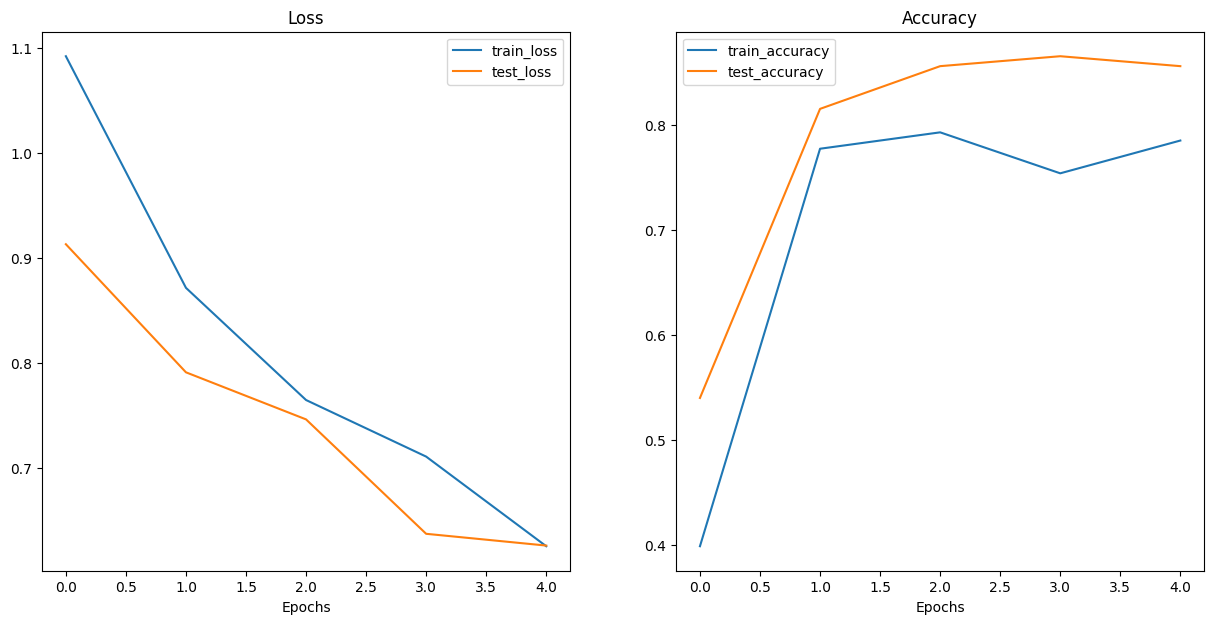

In [24]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [25]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

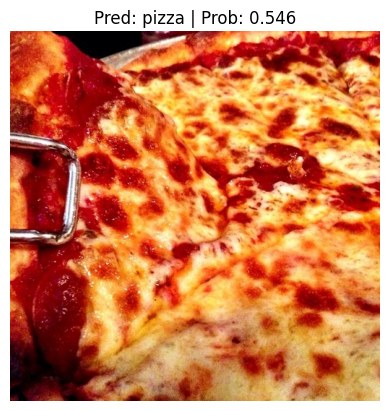

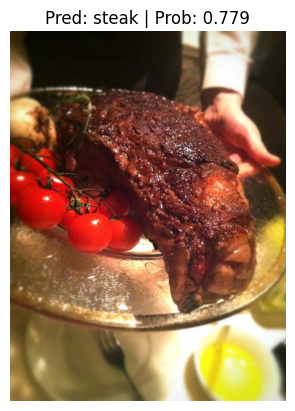

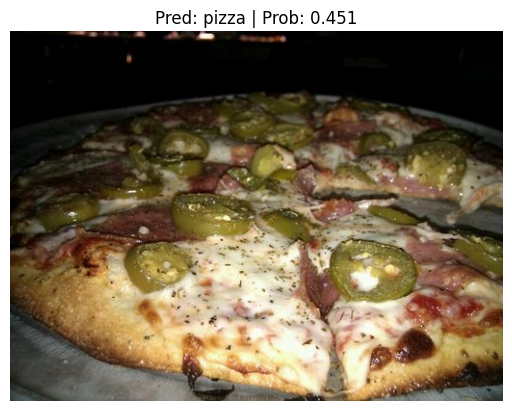

In [26]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))
